### Frame of Problem:
Sensors are deployed on site to collect data. However, the data come with measurement error.  
* Sensors degrade over time. 
* Sensor measurement is subject to environmental factors. 

Suppose one would like to build a model, of which the dependent variable is the predicted true measure, the independent variables are reference sensors and envrionmental factors. This model captures the relationship among these variables when the sensor in question is in the normal state, under which condition the training data is collected.

Instead of deterministic models which output the point-wise prediction for calibration. Stochastic models are preferred to measure both aleatoric uncertainty and epistemic uncertainty. They respectively refer to two problems mentioned before that sensors have. 

* After a peroid of time, the old model will no longer be able to reflect this relationship due to sensor degradation. This may be captured by high deviation (compared against aleatoric uncertainty) from the model prediction at which point epistemic uncertainty is low. In another word, the new observation comes as a surprise for the model. In this case, the model can raise a warning.
* In other cases, one would like to calibrate the sensor data on site by predicting the difference, when the retrieval of the sensors are out of the question.

There are two possible ways of making a neural network stochastic.
* Variational Bayesian by setting priors on a neural network. This can be difficult considering the large number of weights.
* Dropout / Ensemble. In this case, the neural network has to output both the mean and the standard variance (for the quantification of aleatoric uncertainty), of which the loss function must also include these two terms. The epistemic uncertainty is measured by the spread of the various predictions.

In our specific case, the sensor in question is the oxygen sensor from Node 1. The reference snesor is CTD. However, these two sensors are measure at different depths and thus different temperatures. This is also the case in most calibration scenarios where reference sensors and target sensers are in different places. 

The data is formed by joining CTD and Node 1. Further resampling could mitigate the issue of lack of data. Assuming that this data set is collected when sensors are in normal state. We would like to build a stochastic model to describe the relationship between node 1 oxygen sensor (as the dependent variable) and CTD oxygen sensor. CTD is expected to be the ground truth as it is more precise than Node 1. 

We would like to perform $2$ models $\times$ $2$ applications  $= 4$ experiments.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import statsmodels.api as sm
import datetime

### Data Description
What is the data?
How the data is collected?

### Load Data

In [2]:
data_path = "data"

file_Conduvibilita = "TBaia_01m-Conducibilita.txt"
file_CTD = "TBaia_01m-CTD.txt"
file_Ossigeno = "TBaia_01m-Ossigeno.txt"
file_Winkler = "TBaia_01m-Winkler.txt"

In [3]:
def convertTime(x):
    try:
        return pd.to_datetime(x["Data"] + "/" + x["Ora(UTC)"], format="%d/%m/%Y/%H:%M:%S")
    except:
        return -1

################### Conducibilita ###################
Conducibilita_raw_df = pd.read_csv(os.path.join(data_path, file_Conduvibilita), encoding='cp1252', header=None, skiprows=11)
Conducibilita_raw_df.iloc[0, 0] = re.sub("#", "", Conducibilita_raw_df.iloc[0, 0]).strip()
Conducibilita_raw_df = Conducibilita_raw_df.squeeze().str.strip().apply(lambda x: re.sub("\s+", ",", x)).str.split(",", expand=True)
# colNames = Conducibilita_raw_df.iloc[0, :].apply(lambda x: re.split(r"[(\\)\'_]", x)[0])
colNames = Conducibilita_raw_df.iloc[0, :]

Conducibilita_raw_df.columns = colNames
Conducibilita_raw_df = Conducibilita_raw_df.iloc[1:, :]

for j in range(2, Conducibilita_raw_df.shape[1]):
    Conducibilita_raw_df.iloc[:, j] = Conducibilita_raw_df.iloc[:, j].astype(np.float32)

Conducibilita_raw_df["Time"] = Conducibilita_raw_df[["Data", "Ora(UTC)"]].apply(lambda x: convertTime(x), axis=1)
Conducibilita_raw_df["Data"] = Conducibilita_raw_df["Time"].dt.date
Conducibilita_raw_df["Ora(UTC)"] =  Conducibilita_raw_df["Time"].dt.time

################### CTD ###################

CTD_raw_df = pd.read_csv(os.path.join(data_path, file_CTD), encoding='cp1252', header=None, skiprows=15)
CTD_raw_df.iloc[0, 0] = re.sub("#", "", CTD_raw_df.iloc[0, 0]).strip()
CTD_raw_df = CTD_raw_df.squeeze().str.strip().apply(lambda x: re.sub("\s+", ",", x)).str.split(",", expand=True)
# colNames = CTD_raw_df.iloc[0, :].apply(lambda x: re.split(r"[(\\)\'_]", x)[0])
colNames = CTD_raw_df.iloc[0, :]

CTD_raw_df.columns = colNames
CTD_raw_df = CTD_raw_df.iloc[1:, :]

for j in range(2, CTD_raw_df.shape[1]):
    CTD_raw_df.iloc[:, j] = CTD_raw_df.iloc[:, j].astype(np.float32)

CTD_raw_df["Time"] = CTD_raw_df[["Data", "Ora(UTC)"]].apply(lambda x: convertTime(x), axis=1)
CTD_raw_df["Data"] = CTD_raw_df["Time"].dt.date
CTD_raw_df["Ora(UTC)"] =  CTD_raw_df["Time"].dt.time

################### Ossigeno ###################
Ossigeno_raw_df = pd.read_csv(os.path.join(data_path, file_Ossigeno), encoding='cp1252', header=None, skiprows=11)
Ossigeno_raw_df.iloc[0, 0] = re.sub("#", "", Ossigeno_raw_df.iloc[0, 0]).strip()
Ossigeno_raw_df = Ossigeno_raw_df.squeeze().str.strip().apply(lambda x: re.sub("\s+", ",", x)).str.split(",", expand=True)
# colNames = Ossigeno_raw_df.iloc[0, :].apply(lambda x: re.split(r"[(\\)\'_]", x)[0])
colNames = Ossigeno_raw_df.iloc[0, :]

Ossigeno_raw_df.columns = colNames
Ossigeno_raw_df = Ossigeno_raw_df.iloc[1:, :]

for j in range(2, Ossigeno_raw_df.shape[1]):
    Ossigeno_raw_df.iloc[:, j] = Ossigeno_raw_df.iloc[:, j].astype(np.float32)

Ossigeno_raw_df["Time"] = Ossigeno_raw_df[["Data", "Ora(UTC)"]].apply(lambda x: convertTime(x), axis=1)
Ossigeno_raw_df["Data"] = Ossigeno_raw_df["Time"].dt.date
Ossigeno_raw_df["Ora(UTC)"] =  Ossigeno_raw_df["Time"].dt.time

################### Winkler ###################
Winkler_raw_df = pd.read_csv(os.path.join(data_path, file_Winkler), encoding='cp1252', header=None, skiprows=10)
Winkler_raw_df.iloc[0, 0] = re.sub("#", "", Winkler_raw_df .iloc[0, 0]).strip()
Winkler_raw_df = Winkler_raw_df.squeeze().str.strip().apply(lambda x: re.sub("\s+", ",", x)).str.split(",", expand=True)
colNames = Winkler_raw_df.iloc[0, :]
# colNames = Winkler_raw_df.iloc[0, :].apply(lambda x: re.split(r"[(\\)\'_]", x)[0])

Winkler_raw_df.columns = colNames
Winkler_raw_df = Winkler_raw_df.iloc[1:, :]

for j in range(2,  Winkler_raw_df.shape[1]):
    Winkler_raw_df.iloc[:, j] = Winkler_raw_df.iloc[:, j].astype(np.float32)

Winkler_raw_df["Time"] = Winkler_raw_df[["Data", "Ora(UTC)"]].apply(lambda x: convertTime(x), axis=1)
Winkler_raw_df["Data"] = Winkler_raw_df["Time"].dt.date
Winkler_raw_df["Ora(UTC)"] =  Winkler_raw_df["Time"].dt.time

Ossigeno_na_df = Ossigeno_raw_df.where( Ossigeno_raw_df!=-9999, other=None )
Winkler_na_df = Winkler_raw_df.where( Winkler_raw_df!=-9999, other=None )
CTD_na_df = CTD_raw_df.where( CTD_raw_df!=-9999, other=None )
Conducibilita_na_df = Conducibilita_raw_df.where( Conducibilita_raw_df!=-9999, other=None)

In [4]:
Conducibilita_without_na_df = Conducibilita_na_df.dropna()
Ossigeno_without_na_df = Ossigeno_na_df.dropna(subset=["Ossigeno(mg/l)"])
Winkler_without_na_df = Winkler_na_df.dropna()
CTD_without_na_df = CTD_na_df.dropna(subset=["Ossigeno(mg/l)"])

In [5]:
Ossigeno_without_na_sub_df = Ossigeno_without_na_df[["Data", "Ora(UTC)", "Pressione(db)", "Ossigeno(mg/l)", "Temperatura(°C)", "Time"]]
CTD_without_na_sub_df = CTD_without_na_df[["Data", "Ora(UTC)", "Pressione(db)", "Ossigeno(mg/l)", "Temperatura(°C)", "Time"]]

In [6]:
def round_time(x):
    minute = int(round(x.minute / 30)*30)
    if minute == 60:
        if x.hour == 23:
            try:
                x = x.replace(minute=0, hour=0, day=x.day+1)
            except:
                try:
                    x = x.replace(minute=0, hour=0, day=1, month=x.month+1)
                except:
                    x = x.replace(minute=0, hour=0, day=1, month=1, year=x.year+1)
                
        else:
            x = x.replace(minute=0, hour=x.hour+1)
    else:
        x = x.replace(minute=minute)
    x = x.replace(second=0)
    return x

In [7]:
Ossigeno_without_na_sub_df["Time_rounded"] = Ossigeno_without_na_sub_df["Time"]
CTD_without_na_sub_df["Time_rounded"] = CTD_without_na_sub_df["Time"] 
Ossigeno_without_na_sub_df["Time_rounded"] = Ossigeno_without_na_sub_df["Time_rounded"].apply(lambda x: round_time(x))
CTD_without_na_sub_df["Time_rounded"] = CTD_without_na_sub_df["Time_rounded"].apply(lambda x: round_time(x))

/home/qitian/anaconda3/envs/anomaly_seg/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/qitian/anaconda3/envs/anomaly_seg/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/qitian/anaconda3/envs/anomaly_seg/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [8]:
CTD_Ossigeno_df = CTD_without_na_sub_df.merge(Ossigeno_without_na_sub_df, on="Time_rounded", suffixes=("_CTD", "_Ossigeno"))

### Data Visualization

### Model

##### Deterministic

In [43]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, )),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

##### MC Dropout

In [55]:
x = tf.constant([[1, 2, 3]])

In [58]:
x = tf.keras.layers.Dense(3)(x)
x1 = tf.keras.layers.Dense(1)(x)
x2 = tf.keras.layers.Dense(1)(x)

In [65]:
tf.keras.layers.Multiply()([x1, x2])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[7.0036564]], dtype=float32)>

Input1 <- layer_input ( shape = c (1) , dtype = ’ float32 ’, name =’ Input1 ’)
6 Input2 <- layer_input ( shape = c (1) , dtype = ’ float32 ’, name =’ Input2 ’)
7
8 hidden <- list ( Input1 , Input2 ) % >%
9 layer_concatenate % >%
10 layer_dense ( units = neurons [1] , activation =’ tanh ’) % >%
11 layer_dense ( units = neurons [2] , activation =’ tanh ’)
12
13 expectation <- hidden % >%
14 layer_dense ( units = neurons [3] , activation =’ tanh ’) % >%
15 layer_dense ( units =1 , activation =’ linear ’ , name =’ expectation ’)
16
17 standard_deviation <- hidden % >%
18 layer_dense ( units = neurons [4] , activation =’ tanh ’) % >%
19 layer_dense ( units =1 , activation =’ softplus ’)
20
21 variance <- list ( standard_deviation , standard_deviation ) % >% layer_multiply
22 expectation_squared <- list ( expectation , expectation ) % >% layer_multiply
23 second_moment <- list ( variance , expectation_squared ) % >% layer_add ( name =’ second_moment ’)
24
25 model <- keras_model ( inputs =c( Input1 , Input2 ), outputs = c( expectation , second_moment ))
26 model % >% compile ( optimizer = optimizer_rmsprop () ,
27 loss = list ( expectation =’ mse ’, second_moment = ’ mse ’) ,
28 loss_weights = list ( expectation =w1 , second_moment = w2 ))

##### Variational Bayes

In [25]:
CTD_Ossigeno_df.head()

,Data_CTD,Ora(UTC)_CTD,Pressione(db)_CTD,Ossigeno(mg/l)_CTD,Temperatura(°C)_CTD,Time_CTD,Time_rounded,Data_Ossigeno,Ora(UTC)_Ossigeno,Pressione(db)_Ossigeno,Ossigeno(mg/l)_Ossigeno,Temperatura(°C)_Ossigeno,Time_Ossigeno
0,2021-10-07,08:35:00,1.002,6.367,21.628300,2021-10-07 08:35:00,2021-10-07 08:30:00,2021-10-07,08:30:31,0.912,6.34,21.540001,2021-10-07 08:30:31
1,2021-10-13,08:47:00,1.070,7.308,20.351999,2021-10-13 08:47:00,2021-10-13 09:00:00,2021-10-13,09:00:16,0.902,7.37,20.450001,2021-10-13 09:00:16
2,2021-10-19,08:27:00,1.296,7.040,19.583000,2021-10-19 08:27:00,2021-10-19 08:30:00,2021-10-19,08:30:06,1.229,6.82,19.700001,2021-10-19 08:30:06
3,2021-10-25,08:30:00,1.123,7.175,19.200300,2021-10-25 08:30:00,2021-10-25 08:30:00,2021-10-25,08:29:56,1.169,6.88,19.240000,2021-10-25 08:29:56
4,2021-11-03,08:40:00,0.909,7.561,18.356899,2021-11-03 08:40:00,2021-11-03 08:30:00,2021-11-03,08:29:40,1.050,6.92,18.330000,2021-11-03 08:29:40


In [15]:
CTD_Ossigeno_df.shape

(22, 13)

In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

2022-08-26 11:28:26.312156: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-26 11:28:26.317407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 11:28:26.317422: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
y = CTD_Ossigeno_df["Ossigeno(mg/l)_Ossigeno"]

In [26]:
x = CTD_Ossigeno_df[["Pressione(db)_Ossigeno", "Temperatura(°C)_Ossigeno", "Pressione(db)_CTD", "Temperatura(°C)_CTD", "Ossigeno(mg/l)_CTD"]]
x = np.array(x)

###　Resample

In [41]:
np.random.normal(loc=x, scale=[0,1,2,3,4])

array([[ 0.912     , 20.49112839,  0.49378327, 18.74953517, 11.8083835 ],
       [ 0.90200001, 20.32963856,  3.21273826, 13.82130597,  4.31615314],
       [ 1.22899997, 19.14728031,  1.5801141 , 19.27796048, 10.81803086],
       [ 1.16900003, 19.53262296,  1.86164549, 16.78237978,  4.74369094],
       [ 1.04999995, 18.74898355,  0.09744468, 18.96799608,  1.24719882],
       [ 1.20899999, 17.27273657, -3.12269999, 13.11458863,  0.14027652],
       [ 1.16900003, 15.5789784 , -0.04286241, 18.03539069,  5.48177155],
       [ 1.11000001, 15.12696743,  0.26285264, 19.15326162,  5.48764438],
       [ 1.08000004, 13.72188943,  2.49685117,  8.55727772, 10.25771188],
       [ 1.31799996, 12.60086924,  0.16915653, 10.2246093 ,  5.68018141],
       [ 1.20899999, 16.39348773,  2.32892965, 11.18354168,  6.03936843],
       [ 1.18900001, 11.82144682,  3.36217253, 12.68243973,  6.84587664],
       [ 1.29799998, 12.93111661,  4.50341988, 13.11772371,  9.19606839],
       [ 1.33800006, 12.11226365,  1.5

In [ ]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
          tfp.layers.VariableLayer(2 * n, dtype=dtype),
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
              tfd.Normal(loc=t[..., :n],
                         scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
              reinterpreted_batch_ndims=1)),
  ])
    
    # Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

# Build model.
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=10000, verbose=True);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];

Epoch 1/10000


2022-08-26 11:28:56.890098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-26 11:28:56.890250: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-26 11:28:56.890359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-26 11:28:56.909914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-08-26 11:28:56.910075: W tensorflow/stream_executor/platform/default/dso_loader

1/1 [==============================] - 1s 1s/step - loss: 160.9226
Epoch 2/10000
1/1 [==============================] - 0s 6ms/step - loss: 23.1279
Epoch 3/10000
1/1 [==============================] - 0s 7ms/step - loss: 315.2360
Epoch 4/10000
1/1 [==============================] - 0s 6ms/step - loss: 627.6431
Epoch 5/10000
1/1 [==============================] - 0s 6ms/step - loss: 115.0773
Epoch 6/10000
1/1 [==============================] - 0s 7ms/step - loss: 2666.0496
Epoch 7/10000
1/1 [==============================] - 0s 7ms/step - loss: 311.2620
Epoch 8/10000
1/1 [==============================] - 0s 7ms/step - loss: 1237.9594
Epoch 9/10000
1/1 [==============================] - 0s 7ms/step - loss: 57.4669
Epoch 10/10000
1/1 [==============================] - 0s 7ms/step - loss: 15.6830
Epoch 11/10000
1/1 [==============================] - 0s 7ms/step - loss: 214.8833
Epoch 12/10000
1/1 [==============================] - 0s 6ms/step - loss: 6.2645
Epoch 13/10000
1/1 [===========

In [16]:
import matplotlib.pyplot as plt

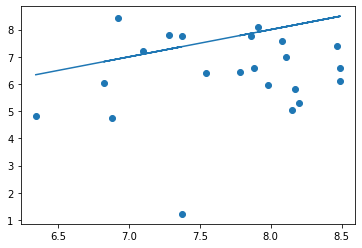

In [19]:
plt.scatter(y, model(np.array(x)).sample())
plt.plot(y, y)